# Data Cleaning

### Correcting Data Types

In [389]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

In [391]:
GP_df = pd.read_csv('gaming_products.csv')

In [393]:
GP_df.head(5)

,Title,Price,Rating Count,Rating,Delivery Time
0,Sceptre Curved 24.5-inch Gaming Monitor up to ...,139.,"6,710",4.4,"Tue, Nov 26"
1,Frigidaire EFMIS179 Gaming Light Up Mini Bever...,52.,662,3.9,"Tue, Nov 26"
2,Sceptre New 27-inch Gaming Monitor 100Hz 1ms D...,98.,"33,593",4.5,"Tue, Nov 26"
3,"LED Light Bar, Music Sync RGB IC Light Bar, US...",15.,115,4.2,"Tue, Nov 26"
4,Logitech G502 HERO High Performance Wired Gami...,37.,"53,190",4.7,NaN


In [395]:
GP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          48 non-null     object 
 1   Price          39 non-null     object 
 2   Rating Count   48 non-null     object 
 3   Rating         48 non-null     float64
 4   Delivery Time  37 non-null     object 
dtypes: float64(1), object(4)
memory usage: 2.0+ KB


In [397]:
GP_df['Price'] = GP_df['Price'].str.replace(",", "", regex=True)


GP_df['Price'] = pd.to_numeric(GP_df['Price'], errors='coerce')

In [399]:
GP_df['Rating Count'] = GP_df['Rating Count'].str.replace(",", "", regex=True)
GP_df['Rating Count'] = pd.to_numeric(GP_df['Rating Count'], errors='coerce')

In [401]:
GP_df['Delivery Time'] = pd.to_datetime(GP_df['Delivery Time'], format="%a, %b %d", errors='coerce')

In [403]:
GP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Title          48 non-null     object        
 1   Price          39 non-null     float64       
 2   Rating Count   48 non-null     int64         
 3   Rating         48 non-null     float64       
 4   Delivery Time  37 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 2.0+ KB


In [405]:
GP_df.head(5)

,Title,Price,Rating Count,Rating,Delivery Time
0,Sceptre Curved 24.5-inch Gaming Monitor up to ...,139.0,6710,4.4,1900-11-26
1,Frigidaire EFMIS179 Gaming Light Up Mini Bever...,52.0,662,3.9,1900-11-26
2,Sceptre New 27-inch Gaming Monitor 100Hz 1ms D...,98.0,33593,4.5,1900-11-26
3,"LED Light Bar, Music Sync RGB IC Light Bar, US...",15.0,115,4.2,1900-11-26
4,Logitech G502 HERO High Performance Wired Gami...,37.0,53190,4.7,NaT


### Determine methods to fill Missing values 

##### checking correlation to decide how to fill the data

In [409]:
GP_df[['Rating Count', 'Rating', 'Price']].corr()

,Rating Count,Rating,Price
Rating Count,1.000000,0.296818,-0.157820
Rating,0.296818,1.000000,0.115799
Price,-0.157820,0.115799,1.000000


not correlate each with each other as close to 0s, let's visualize it

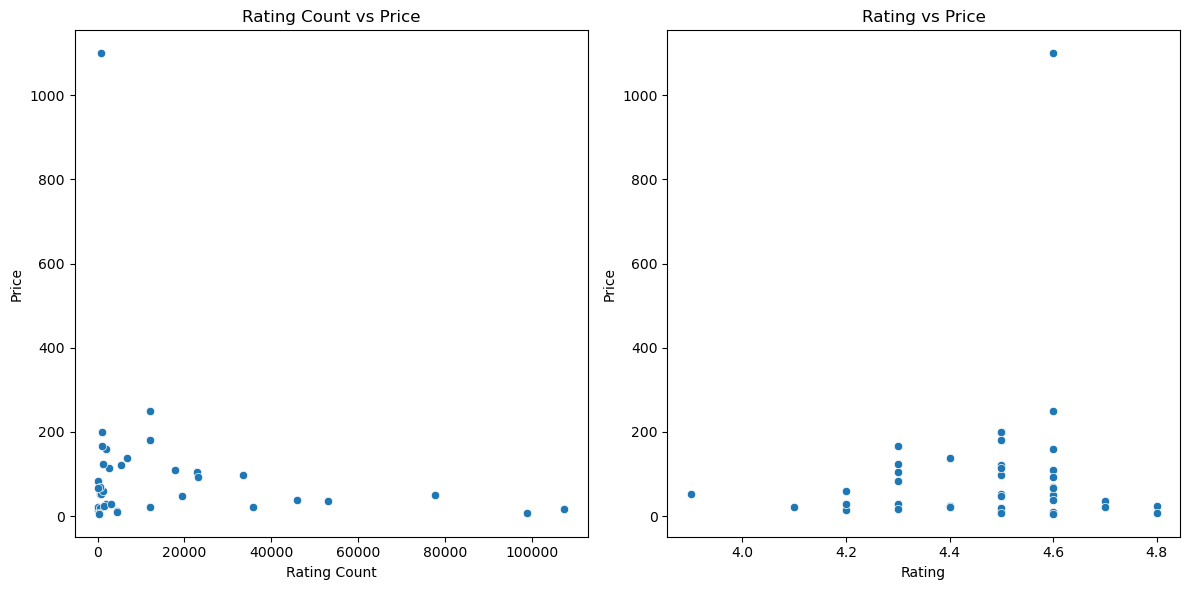

In [412]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=GP_df['Rating Count'], y=GP_df['Price'])
plt.title('Rating Count vs Price')

plt.subplot(1, 2, 2)
sns.scatterplot(x=GP_df['Rating'], y=GP_df['Price'])
plt.title('Rating vs Price')

plt.tight_layout()
plt.show()

### Note:

> as we did model evaluation so **rating count or rating is not depending on price** so we we continue our process with clustering

### clustering the data before handling missing values as different categorize product exists

In [415]:
GP_df['Price'].describe()

count      39.000000
mean       96.897436
std       175.552481
min         6.000000
25%        21.500000
50%        52.000000
75%       111.500000
max      1099.000000
Name: Price, dtype: float64

In [417]:
GP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Title          48 non-null     object        
 1   Price          39 non-null     float64       
 2   Rating Count   48 non-null     int64         
 3   Rating         48 non-null     float64       
 4   Delivery Time  37 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 2.0+ KB


checking for how much clusters will make impact

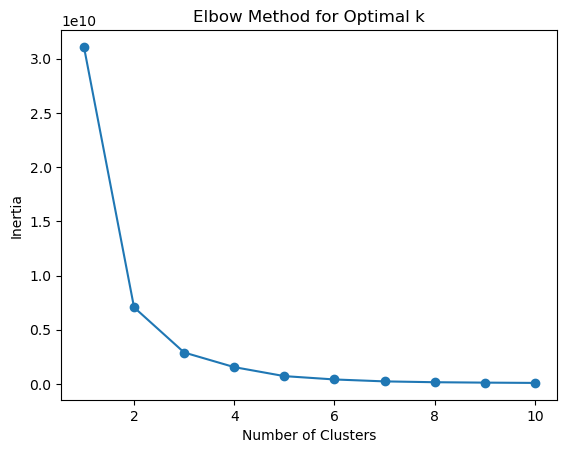

In [420]:
import matplotlib.pyplot as plt

# Test for a range of cluster sizes
inertia_values = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot Inertia vs Number of Clusters
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


The elbow point in this graph appears at k=3 or k=4, where the inertia drops sharply initially (from k=1 to k=3) and then slows down significantly, indicating diminishing returns. Beyond k=4, the line flattens, suggesting additional clusters add little value to improving the fit. Hence, k=3 or k=4 is a reasonable choice for the optimal number of clusters.

In [423]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X = GP_df[['Rating Count', 'Rating']] 
y = GP_df['Price'] 

# Cluster the data
kmeans = KMeans(n_clusters=3,  n_init=10, random_state=42)  # Set the number of clusters
X_complete = X.dropna()  # Remove rows with missing values in features
kmeans.fit(X_complete)


# Predict clusters for the full data
GP_df['cluster'] = kmeans.predict(X)

In [425]:
GP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Title          48 non-null     object        
 1   Price          39 non-null     float64       
 2   Rating Count   48 non-null     int64         
 3   Rating         48 non-null     float64       
 4   Delivery Time  37 non-null     datetime64[ns]
 5   cluster        48 non-null     int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 2.2+ KB


In [427]:
GP_df.head(5)

,Title,Price,Rating Count,Rating,Delivery Time,cluster
0,Sceptre Curved 24.5-inch Gaming Monitor up to ...,139.0,6710,4.4,1900-11-26,0
1,Frigidaire EFMIS179 Gaming Light Up Mini Bever...,52.0,662,3.9,1900-11-26,0
2,Sceptre New 27-inch Gaming Monitor 100Hz 1ms D...,98.0,33593,4.5,1900-11-26,2
3,"LED Light Bar, Music Sync RGB IC Light Bar, US...",15.0,115,4.2,1900-11-26,0
4,Logitech G502 HERO High Performance Wired Gami...,37.0,53190,4.7,NaT,2


In [429]:
GP_df.groupby('cluster')['Price'].mean()

cluster
0    112.642857
1     25.333333
2     68.625000
Name: Price, dtype: float64

In [431]:
GP_df.groupby('cluster')['Rating'].mean()

cluster
0    4.427273
1    4.550000
2    4.554545
Name: Rating, dtype: float64

In [433]:
GP_df.groupby('cluster')['Rating Count'].mean()

cluster
0     3532.484848
1    88761.750000
2    29158.181818
Name: Rating Count, dtype: float64

### now filling values base on clusters

In [436]:
cluster_means = GP_df.groupby('cluster')['Price'].mean()

# Fill missing values by assigning the mean 'Price' of the corresponding cluster
GP_df['Price'] = GP_df.apply(
    lambda row: cluster_means[row['cluster']] if pd.isna(row['Price']) else row['Price'],
    axis=1
)

In [438]:
GP_df['Price'].describe()

count      48.000000
mean       95.279638
std       158.432680
min         6.000000
25%        24.750000
50%        67.312500
75%       112.642857
max      1099.000000
Name: Price, dtype: float64

filled desired values with very less varance in actuall dat

In [441]:
GP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Title          48 non-null     object        
 1   Price          48 non-null     float64       
 2   Rating Count   48 non-null     int64         
 3   Rating         48 non-null     float64       
 4   Delivery Time  37 non-null     datetime64[ns]
 5   cluster        48 non-null     int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 2.2+ KB


In [443]:
GP_df.head(5)

,Title,Price,Rating Count,Rating,Delivery Time,cluster
0,Sceptre Curved 24.5-inch Gaming Monitor up to ...,139.0,6710,4.4,1900-11-26,0
1,Frigidaire EFMIS179 Gaming Light Up Mini Bever...,52.0,662,3.9,1900-11-26,0
2,Sceptre New 27-inch Gaming Monitor 100Hz 1ms D...,98.0,33593,4.5,1900-11-26,2
3,"LED Light Bar, Music Sync RGB IC Light Bar, US...",15.0,115,4.2,1900-11-26,0
4,Logitech G502 HERO High Performance Wired Gami...,37.0,53190,4.7,NaT,2


In [447]:
GP_df.to_csv('gaming_products_Cleaned.csv', index=False)